# Merge overlapping striplogs

Imagine we have a Striplog with overlapping Interval. We would like to be able to merge the Intervals in this Striplog, while following some rules about priority. 

For example, imagine we have a striplog object, as shown below on the left. Note that the Intervals in the striplog have a `time` property, so I've 'exploded' that out along the horizontal axis so the Intervals don't all overlap in this display. The point is that they overlap in depth.

<img src="./merging.png" />

**NB** This other property does not have to be time, it could be any property that we can use to make comparisons.

**NB again** The 'mix' (blended) merges indicated in the figure have not been implemented yet.

## Make some data

Let's make some striplogs that look like these...

In [1]:
from striplog import Striplog

csv = """Top,Base,Comp Time,Comp Depth
100,200,2,a
110,120,1,b
150,325,3,c
210,225,1,d
300,400,2,e
350,375,3,f
"""

s = Striplog.from_csv(text=csv)

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/striplog/striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


Here's what the first Interval looks like:

In [2]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 200.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'time': 2.0, 'depth': 'a'})]})

We'll need a `Legend` so we can make nice plots:

In [3]:
from striplog import Legend

# Data for legend (for display)...
leg_csv = """Colour,Comp Depth
red,a
orange,b
limegreen,c
cyan,d
blue,e
magenta,f
"""

legend = Legend.from_csv(text=leg_csv)

Now we can make a plot. I'll make the Intervals semi-transparent so you can see how they overlap:

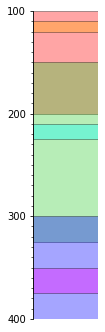

In [4]:
s.plot(legend=legend, lw=1, aspect=3, alpha=0.35)

It's not all that pretty, but we can also plot each time separately as in the figure we started with:

(420.0, 80.0)

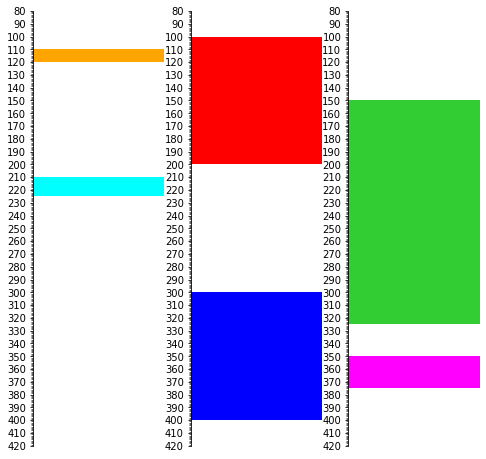

In [5]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True, figsize=(8, 8))
s.find('1.0').plot(legend=legend, ax=ax0)
s.find('2.0').plot(legend=legend, ax=ax1)
s.find('3.0').plot(legend=legend, ax=ax2)
plt.ylim(420, 80)

## Merge

We'd like to merge the Intervals so that everything retains depth order of course, but we want a few options about which Intervals should 'win' when there are several Intervals overlapping. For example, when looking at a particular depth, do we want to retain the Interval with the shallowest top? Or the deepest base? Or the greatest thickess? Or the one from the latest `time`?

In [6]:
s[0]

Interval({'top': Position({'middle': 100.0, 'units': 'm'}), 'base': Position({'middle': 200.0, 'units': 'm'}), 'description': '', 'data': {}, 'components': [Component({'time': 2.0, 'depth': 'a'})]})

So if we merge using `top` as a priority, we'll get whichever Interval has the greatest (deepest) `top` at any given depth:

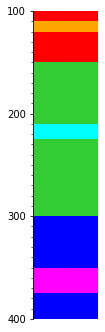

In [7]:
s.merge('top').plot(legend=legend, aspect=3)

If we use `reverse=True` then we get whichever has the shallowest top:

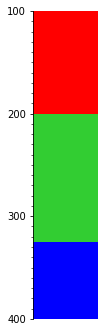

In [8]:
s.merge('top', reverse=True).plot(legend=legend, aspect=3)

## Thickness priority

What if we want to keep the thickest bed at any given depth?

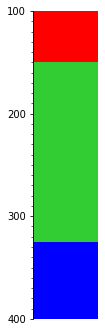

In [9]:
s.merge('thickness').plot(legend=legend, aspect=3)

Or the thinnest bed?

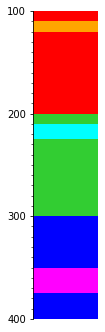

In [10]:
s.merge('thickness', reverse=True).plot(legend=legend, aspect=3)

## Using the other attribute

Remember we also have the time attribute? We could use that... we'll end up with which bed has the greatest (i.e. latest) top:

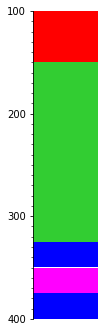

In [11]:
s.merge('time').plot(legend=legend, aspect=3)

...or earliest:

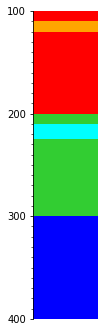

In [12]:
s.merge('time', reverse=True).plot(legend=legend, aspect=3)

## Real data example

Intervals are perforations. Many of them overlap. They all have datetimes. For a given depth, we want to keep the _latest_ perforation.

In [14]:
from striplog import Striplog

remap = {'bottom':'base','type':'comp type'}
s = Striplog.from_csv("og815.csv", remap=remap)

/home/matt/miniconda3/envs/welly/lib/python3.9/site-packages/striplog/striplog.py:512: UserWarning: No lexicon provided, using the default.
  warnings.warn(w)


In [15]:
from datetime import datetime

for iv in s:
    iv.primary.date = datetime.fromisoformat(iv.data['date'])

In [16]:
s[1]

Interval({'top': Position({'middle': 1992.0, 'units': 'm'}), 'base': Position({'middle': 2005.0, 'units': 'm'}), 'description': '', 'data': {'': 37.0, 'wells': 'OG-815', 'date': '2008-06-23'}, 'components': [Component({'type': 'perforation', 'date': datetime.datetime(2008, 6, 23, 0, 0)})]})

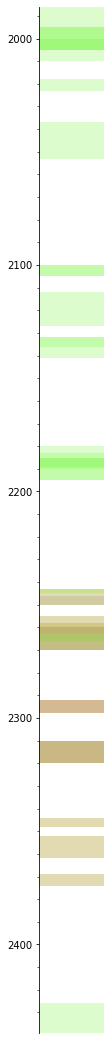

In [17]:
s.plot(alpha=0.25)

### Merge the perfs

Now we can merge based on date:

In [18]:
sm = s.merge('date')

In [19]:
leg = """colour,comp type
limegreen,perforation
red,squeeze"""

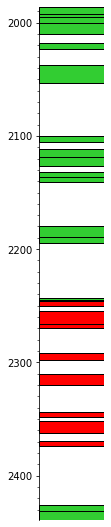

In [20]:
from striplog import Legend

legend = Legend.from_csv(text=leg)

sm.plot(legend, lw=1, aspect=5)

In [21]:
sm.find_overlaps()

There are none, that's good!

## Export to Petrel

In [22]:
print(sm.to_csv())

Top,Base,Component
1986.0,1992.0,"Perforation, 2008-06-24 00:00:00"
1992.0,1995.0,"Perforation, 2008-06-23 00:00:00"
1995.0,2000.0,"Perforation, 2015-11-14 00:00:00"
2000.0,2010.0,"Perforation, 2018-07-31 00:00:00"
2018.0,2023.0,"Perforation, 2009-10-23 00:00:00"
2037.0,2053.0,"Perforation, 2009-10-23 00:00:00"
2100.0,2105.0,"Perforation, 2018-07-31 00:00:00"
2112.0,2119.0,"Perforation, 2008-04-28 00:00:00"
2119.0,2127.0,"Perforation, 2008-04-28 00:00:00"
2132.0,2136.0,"Perforation, 2012-05-30 00:00:00"
2136.0,2141.0,"Perforation, 2002-06-05 00:00:00"
2180.0,2189.0,"Perforation, 2015-11-14 00:00:00"
2189.0,2195.0,"Perforation, 2015-11-13 00:00:00"
2243.0,2245.0,"Perforation, 2012-05-29 00:00:00"
2245.0,2246.0,"Squeeze, 2008-04-28 00:00:00"
2246.0,2250.0,"Squeeze, 2002-06-03 00:00:00"
2255.0,2266.0,"Squeeze, 2008-04-28 00:00:00"
2266.0,2270.0,"Squeeze, 2002-06-03 00:00:00"
2292.0,2298.0,"Squeeze, 2002-06-03 00:00:00"
2310.0,2320.0,"Squeeze, 2002-06-03 00:00:00"
2344.0,2348.0,"Squeeze, 1

This isn't quite right for Petrel.

Let's make another format.

In [23]:
def _to_petrel_csv(strip, attr, null):
    """
    Make Petrel-ready CSV text for a striplog
    """
    csv = ""
    gap_top = 0
    for iv in strip.merge_neighbours():
        if iv.top.middle != gap_top:
            csv += f"{gap_top},{null}\n"
        csv += f"{iv.top.middle},{getattr(iv.primary, attr)}\n"
        gap_top = iv.base.middle
    csv += f"{iv.base.middle},{null}\n"
    return csv

def to_petrel(fname, strip, attr, null=None):
    """
    Make a Petrel-ready CSV file.
    
    Args
        fname (str): the filename, including extension
        strip (Striplog): the striplog
        null (str): what to use for nulls
        
    Returns
        None (writes file as side effect)
    """
    if null is None:
        null = "-999.25"
    with open(fname, 'w') as f:
        f.write(_to_petrel_csv(strip, attr, null))
    return

In [24]:
print(_to_petrel_csv(sm, attr='type', null=-999.25))

0,-999.25
1986.0,perforation
2010.0,-999.25
2018.0,perforation
2023.0,-999.25
2037.0,perforation
2053.0,-999.25
2100.0,perforation
2105.0,-999.25
2112.0,perforation
2127.0,-999.25
2132.0,perforation
2141.0,-999.25
2180.0,perforation
2195.0,-999.25
2243.0,perforation
2245.0,squeeze
2250.0,-999.25
2255.0,squeeze
2270.0,-999.25
2292.0,squeeze
2298.0,-999.25
2310.0,squeeze
2320.0,-999.25
2344.0,squeeze
2348.0,-999.25
2352.0,squeeze
2362.0,-999.25
2369.0,squeeze
2374.0,-999.25
2426.0,perforation
2439.0,-999.25



In [25]:
to_petrel("well_for_petrel.csv", sm, attr='type')

---

&copy; 2020 Agile Scientific, licenced CC-BY